In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

True

In [3]:
K.clear_session()

In [4]:
# use ImageDataGenerator to transform image data to data matrics
nrow = 150
ncol = 150

train_data_dir = './train'
batch_size = 500
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

test_data_dir = './test'
batch_size = 500
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 3375 images belonging to 9 classes.
Found 1125 images belonging to 9 classes.


In [5]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)
    
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:966: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


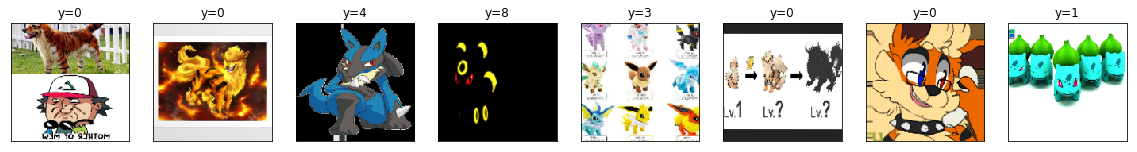

In [6]:
train_generator.reset()
Xtr, ytr = train_generator.next()
nplot = 8
plt.figure(figsize=(20,10))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    disp_image(Xtr[i])
    plt.title('y=%d' % ytr[i])

In [7]:
test_generator.reset()
Xts, yts = test_generator.next()

In [8]:
# image date reshape and combination
# flatten to 2D images
X1 = Xtr.reshape(Xtr.shape[0], 67500)
X2 = Xts.reshape(Xts.shape[0], 67500)
X = np.vstack((X1, X2))
y = np.hstack((ytr, yts))
print("X shape before scaling: ", X.shape)
print("y shape before scaling: ", y.shape)

X shape before scaling:  (1000, 67500)
y shape before scaling:  (1000,)


In [9]:
nsamp, nfeatures = X.shape
nclass = np.max(y) + 1
print('num samples   = %d' % nsamp)
print('num features  = %d' % nfeatures)
print('num classeses = %d' % nclass)

num samples   = 1000
num features  = 67500
num classeses = 9


In [10]:
# data scaling
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()
scaling.fit(X)
Xs = scaling.transform(X)
Xs.shape

(1000, 67500)

In [11]:
# fit PCA on the entire transformed data Xs
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', whiten=True)
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

initial npc:  227


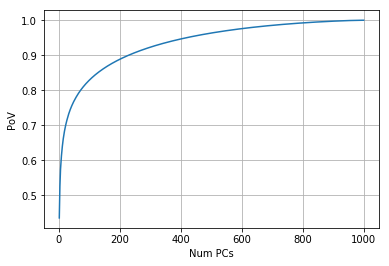

In [12]:
# calculate and plot PoV to find the number of PCs to start with
s = pca.singular_values_**2
pov = np.cumsum(s)/np.sum(s)
numpc = np.arange(1,nsamp+1)
plt.plot(numpc,pov,'-')
plt.xlabel('Num PCs')
plt.ylabel('PoV')
plt.grid()

# Set number of PCs = first component where pov >= 0.9
I = np.where(pov >= 0.9)[0]
npc_opt = I[0]
print("initial npc: ", npc_opt)

In [13]:
from sklearn.svm import SVC

In [14]:
Itr = int(Xs.shape[0] * 0.75)
Xtr = Xs[:Itr]
ytr = y[:Itr]
Xts = Xs[Itr:]
yts = y[Itr:]

In [15]:
npc_test = np.arange(2,npc_opt+1, 10)
gam_test = [1e-4, 4e-4,1e-3,1e-2]
c = 1e+4
n0 = len(npc_test)
n1 = len(gam_test)
acc = np.zeros((n0,n1))
acc_max = 0

for i0, npc in enumerate(npc_test):
    
    # Fit PCA on the training data
    pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
    pca.fit(Xtr)

    # Transform the training and test
    Ztr = pca.transform(Xtr)
    Zts = pca.transform(Xts)
    
    for i1, gam in enumerate(gam_test):
                
        # Fiting on the transformed training data
        svc = SVC(C=c, kernel='rbf', gamma = gam)
        svc.fit(Ztr, ytr)
        
        # Predict on the test data
        yhat = svc.predict(Zts)
        
        # Compute the accuracy
        acc[i0,i1] = np.mean(yhat == yts)
        print('npc=%d gam=%12.4e acc=%12.4e' % (npc,gam,acc[i0,i1]))
        
        # Save the optimal parameters
        if acc[i0,i1] > acc_max:
            gam_opt = gam
            npc_opt = npc
            acc_max = acc[i0,i1]

npc=2 gam=  1.0000e-04 acc=  1.8400e-01
npc=2 gam=  4.0000e-04 acc=  1.8400e-01
npc=2 gam=  1.0000e-03 acc=  2.1600e-01
npc=2 gam=  1.0000e-02 acc=  2.0400e-01
npc=12 gam=  1.0000e-04 acc=  3.9600e-01
npc=12 gam=  4.0000e-04 acc=  4.0800e-01
npc=12 gam=  1.0000e-03 acc=  4.0400e-01
npc=12 gam=  1.0000e-02 acc=  3.1200e-01
npc=22 gam=  1.0000e-04 acc=  3.6800e-01
npc=22 gam=  4.0000e-04 acc=  3.6400e-01
npc=22 gam=  1.0000e-03 acc=  3.6000e-01
npc=22 gam=  1.0000e-02 acc=  3.3200e-01
npc=32 gam=  1.0000e-04 acc=  3.4800e-01
npc=32 gam=  4.0000e-04 acc=  4.2000e-01
npc=32 gam=  1.0000e-03 acc=  3.6800e-01
npc=32 gam=  1.0000e-02 acc=  3.8800e-01
npc=42 gam=  1.0000e-04 acc=  3.6000e-01
npc=42 gam=  4.0000e-04 acc=  3.4000e-01
npc=42 gam=  1.0000e-03 acc=  3.2000e-01
npc=42 gam=  1.0000e-02 acc=  3.4800e-01
npc=52 gam=  1.0000e-04 acc=  3.4800e-01
npc=52 gam=  4.0000e-04 acc=  3.2000e-01
npc=52 gam=  1.0000e-03 acc=  3.2000e-01
npc=52 gam=  1.0000e-02 acc=  3.4800e-01
npc=62 gam=  1.0000e

Optimal num PCs = 32
Optimal gamma   = 0.000400
Optimal accuracy = 0.420000


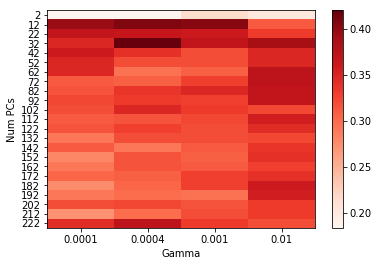

In [44]:
plt.imshow(acc, aspect='auto', cmap='Reds')
plt.xlabel('Gamma')
plt.ylabel('Num PCs')
plt.colorbar()

ax = plt.gca()
ax.set_xticks(np.arange(0,n1))
ax.set_xticklabels(gam_test)
ax.set_yticks(np.arange(0,n0))
_ = ax.set_yticklabels(npc_test)

print('Optimal num PCs = %d' % (npc_opt))
print('Optimal gamma   = %f' % (gam_opt))
i0 = np.where(npc_test == npc_opt)[0][0]
i1 = gam_test.index(gam_opt)
print('Optimal accuracy = %f' % (acc[i0][i1]))